# URL clustering based on similarity

- urls_df = full dataset
- urls_tdf = full dataset transformed
- urls_tsdf = sampled dataset transformed

## Imports & Helper functions

### Save or load jupyter session

### Imports

In [ ]:
import pickle
import time
import warnings
from math import log

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import smaz
import tldextract
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import Birch
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler

warnings.filterwarnings("ignore")

sns.set()

### Helper functions

In [ ]:
from polyleven import levenshtein


def levenshtein_pdist(u, v):
    if isinstance(u, np.ndarray):
        u = u[0]
    if isinstance(v, np.ndarray):
        v = v[0]
    return levenshtein(u, v)

## Preprocessing

In [ ]:
def load_data():
    return pd.read_csv(
        "datasets/kaggle_siddharta_malicious_benign.csv",
        delimiter=",",
        dtype={"url": "string"},
    )


urls_df = load_data()
urls_df.info()

### Non TF-IDF

#### Data extraction & cleaning

##### Extract Fully Qualified Domain Names (FQDNs) from URLs

In [ ]:
def extract_FQDNs(df):
    # Regex pattern to extract fully qualified domain name (FQDN)
    pattern = r"(?:.*?:\/\/)?(?P<www>[wW]{3}\.)?(?P<domain>[\w\.\-]+)[^\w]*"

    # Execute regex over URLs
    match = df["url"].str.extract(pattern)

    # Extract domain using named group
    df["FQDN"] = match["domain"]

    # Indicate if www subdomain is present
    df["has_www"] = match["www"].notna()

    return df

##### Remove all addreses without domain (IPs)

In [ ]:
def clean_data(df):
    # Pattern that matches all IPv4 addresses
    pattern = "(?:.*?:\/\/)?(?P<www>[wW]{3}\.)?[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}([/:].*)?$"

    # Leave only data not containing pure IPv4
    df = df[~df["url"].str.match(pattern)]

    # Remove all data with non-unique FQDN
    df = df.drop_duplicates(subset="FQDN")

    # Drop type column, after the previous step it is useless
    df = df.drop("type", axis=1)

    # Reset index
    df = df.reset_index(drop=True)

    return df

##### Separate TLD, domain and subdomain

In [ ]:
# Function to extract components of domain using tldextract
def extract_domain_components(url):
    ext = tldextract.extract(url)
    return pd.Series([ext.subdomain, ext.domain, ext.suffix, ext.suffix == ""])

In [ ]:
def expand_fqdns(df):
    # Apply function to url column to extract domain components and explode into separate columns
    df[["subdomain", "domain", "TLD", "is_invalid_TLD"]] = df["url"].apply(
        extract_domain_components
    )

    return df

In [ ]:
def clean_invalid_domains(df):
    # Remove domains with invalid TLD
    df = df[~df["is_invalid_TLD"]]

    # Remove unused is_invalid_TLD
    df = df.drop("is_invalid_TLD", axis=1)

    # Reset index
    df = df.reset_index(drop=True)

    return df

##### Length of domain, subdomain and TLD

In [ ]:
def extract_lengths(df):
    df[["domain_length", "subdomain_length", "TLD_length"]] = df[
        ["domain", "subdomain", "TLD"]
    ].applymap(len)

    return df

##### Number of subdomains

I decide to include www in the count of subdomains. Might make performance-wise issues later. Reconsider if needed

In [ ]:
def extract_subdomains_count(df):
    df["num_of_subdomains"] = (
        df["subdomain"].str.split(".").apply(lambda x: len(x) if x != [""] else 0)
    )

    return df

##### Characters frequency & vowel-to-consonant ratio
Characters:
- alphabetical - "a-zA-Z"
- digits - "0-9"
- special - all except alphabetical, digits and dot

Can be changed based on the occurences of dots. It may be better to remove dots so this information is uncorrelated with num_of_substrings

Try the result with and without dots to analyze the difference

In [ ]:
def extract_char_frequency_vowel_consonant_ratio(df):
    for column in ["domain", "subdomain", "TLD"]:
        # Vowel-to-consonant ratio
        vowel_counts = df[column].str.count(r"[aeiouAEIOU]")
        consonant_counts = df[column].str.count(r"[b-df-hj-np-tv-zB-DF-HJ-NP-TV-Z]")

        # Get alphabetical, numeric and special character counts for specific column
        numeric_counts = df[column].str.count(r"[0-9]")
        special_counts = df[column].str.count(r"[^A-Za-z0-9\s\.]")
        alpha_counts = vowel_counts + consonant_counts

        # Add them into DF
        df[
            [
                f"{column}_alpha_count",
                f"{column}_numeric_count",
                f"{column}_special_count",
                f"{column}_vowel_consonant_ratio",
            ]
        ] = pd.Series(
            [
                alpha_counts,
                numeric_counts,
                special_counts,
                vowel_counts / consonant_counts,
            ]
        )

    return df

##### Complexity of domain and subdomain

Using compression algorithm (`smaz` python implementation) to approximate Kolmogorov complexity

In [ ]:
def approximate_kolmogorov_complexity(df):
    df[["FQDN_complexity"]] = df[["FQDN"]].applymap(
        lambda s: len(smaz.compress(s)) / len(s) if s != "" else np.nan
    )

    return df

#### Feature imputation, scaling & selection

In [ ]:
def impute_values(df):
    # Replace NaN values with zeros
    df.fillna(0, inplace=True)

    # Replace infinities with the maximum finite value in each column
    df = df.replace([np.inf, -np.inf], np.nan)
    max_values = df.max()

    df.fillna(max_values, inplace=True)

    return df

In [ ]:
def slice_dataset(df):
    df = df.iloc[:, 6:]

    return df

In [ ]:
def scale_features(df):
    ssc = StandardScaler()

    df = ssc.fit_transform(df)

    return df

In [ ]:
def select_features(df):
    pca = PCA(n_components=0.95)
    df = pca.fit_transform(df)

    return df

In [ ]:
def extract_features(df):
    df = df.copy()
    df = extract_FQDNs(df)
    df = clean_data(df)
    df = expand_fqdns(df)
    df = clean_invalid_domains(df)
    df = extract_lengths(df)
    df = extract_subdomains_count(df)
    df = extract_char_frequency_vowel_consonant_ratio(df)
    df = approximate_kolmogorov_complexity(df)

    return df

In [ ]:
def transform_features(df):
    df = df.copy()

    df = impute_values(df)
    df = slice_dataset(df)

    # From here data is in np.ndarray
    matrix = scale_features(df)
    matrix = select_features(matrix)

    sparse_matrix = sp.csr_matrix(matrix)

    return sparse_matrix

### TF-IDF

#### Incremental wrapper

In [ ]:
class IncrementalTfidf:
    """
    A class to process text data in chunks and incrementally compute character-level TF-IDF values.

    Attributes:
    -----------
    hashing_vectorizer : HashingVectorizer
        Vectorizer that converts text data to a term-document matrix using the hashing trick
    tfidf_transformer : TfidfTransformer
        Transformer that computes TF-IDF values from the term-document matrix
    X_counts : scipy.sparse matrix
        Accumulated term-document matrix
    X_tfidf : scipy.sparse matrix
        Accumulated TF-IDF representation
    """

    def __init__(
        self,
        ngram_range=(1, 1),
        n_features=2**20,
        column_name="",
    ):  # Default value for n_features in HashingVectorizer
        """
        Initializes the IncrementalTfidf with a HashingVectorizer and TfidfTransformer.
        """
        self.hashing_vectorizer = HashingVectorizer(
            analyzer="char",
            token_pattern=None,
            n_features=n_features,
            ngram_range=ngram_range,
        )
        self.tfidf_transformer = TfidfTransformer()
        self.X_counts = None
        self.X_tfidf = None
        self.column_name = column_name

    def update_tf_counts(self, chunk):
        """
        Updates the term-document matrix with the new chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data
        """
        # Transform the chunk of text data into a term-document matrix using the HashingVectorizer
        chunk_counts = self.hashing_vectorizer.transform(chunk)

        # If this is the first chunk, set the term-document matrix to the transformed chunk
        if self.X_counts is None:
            self.X_counts = chunk_counts
        else:
            # Otherwise, stack the transformed chunk to the existing term-document matrix
            self.X_counts = sp.vstack((self.X_counts, chunk_counts))

    def update_idf(self):
        """
        Updates the TfidfTransformer based on the current term-document matrix.
        """
        self.tfidf_transformer.fit(self.X_counts)

    def partial_fit(self, chunk):
        """
        Updates the term-document matrix and fits the TfidfTransformer with the new chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data

        Returns:
        --------
        self : IncrementalTfidf
            The instance of the IncrementalTfidf
        """
        self.update_tf_counts(chunk)
        self.update_idf()
        return self

    def transform(self, chunk):
        """
        Transforms the given chunk of text data to a TF-IDF representation.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            Chunk of text data to be transformed

        Returns:
        --------
        chunk_tfidf : scipy.sparse matrix
            Transformed chunk in TF-IDF representation
        """
        chunk_counts = self.hashing_vectorizer.transform(chunk)
        chunk_tfidf = self.tfidf_transformer.transform(chunk_counts)
        return chunk_tfidf

    def partial_fit_transform(self, chunk):
        """
        Updates the term-document matrix, fits the TfidfTransformer, and transforms the given chunk of text data.

        Parameters:
        -----------
        chunk : pandas.Series or list of str
            New chunk of text data

        Returns:
        --------
        chunk_tfidf : scipy.sparse matrix
            Transformed chunk in TF-IDF representation
        """
        self.partial_fit(chunk)
        return self.transform(chunk)

    def compute_tfidf(self):
        """
        Retrieves the accumulated TF-IDF representation of the processed text data.

        Returns:
        --------
        X_tfidf : scipy.sparse matrix
            Accumulated TF-IDF representation
        """
        self.X_tfidf = self.tfidf_transformer.transform(self.X_counts)
        return self.X_tfidf

#### The code

In [ ]:
def fit_vectorizers(df, columns, ngram_range):
    fitted_tfidf_vectorizers = []

    for column in columns:
        incremental_tfidf = IncrementalTfidf(ngram_range=ngram_range)

        incremental_tfidf.partial_fit(df[column])

        fitted_tfidf_vectorizers.append(incremental_tfidf)

    return fitted_tfidf_vectorizers

In [ ]:
def get_tfidf_matrices(fitted_vectorizers):
    return [
        incremental_tfidf.compute_tfidf() for incremental_tfidf in fitted_vectorizers
    ]

#### TF-IDF selection parameter tuning

In [ ]:
# Open the file in binary mode
with open("domain_n_components_search.pkl", "rb") as file:
    components_variance_time_d = pickle.load(file)

with open("subdomain_n_components_search.pkl", "rb") as file:
    components_variance_time_s = pickle.load(file)

In [ ]:
components_variance_time_d

In [ ]:
components_variance_time_s

In [ ]:
# Plot the cumulative explained variance ratio as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(
    components_variance_time_d["n_components"],
    components_variance_time_d["explained_variance"],
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components - Domains")
plt.show()

In [ ]:
# Plot the cumulative explained variance ratio as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(
    components_variance_time_s["n_components"],
    components_variance_time_s["explained_variance"],
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components - Subdomains")
plt.show()

In [ ]:
# Open the file in binary mode
with open("domain_n_components_search.pkl", "wb") as file:
    pickle.dump(components_variance_time_d, file)

with open("subdomain_n_components_search.pkl", "wb") as file:
    pickle.dump(components_variance_time_s, file)

#### TF-IDF feature selection

In [424]:
# dom 350
# sub 300


def lsa_selection(tfidf_matrices, n_components):

    selected_matrices = []
    explained_variances = []

    for i, tfidf_matrix in enumerate(tfidf_matrices):
        lsa = make_pipeline(
            TruncatedSVD(n_components=n_components[i]), Normalizer(copy=False)
        )

        X_lsa = lsa.fit_transform(tfidf_matrix)

        selected_matrices.append(X_lsa)
        explained_variances.append(lsa[0].explained_variance_ratio_.sum())

    return (selected_matrices, explained_variances)

In [423]:
def preprocess_tfidf(df, columns, ngram_range, n_components):
    fitted_vectorizers = fit_vectorizers(df, columns, ngram_range)
    tfidf_matrices = get_tfidf_matrices(fitted_vectorizers)
    tfidf_lsa, explained_variances = lsa_selection(tfidf_matrices, n_components)

    # for i, variance in enumerate(explained_variances):
    #     print(
    #         f"Explained variance of {columns[i]} in the SVD step: {variance * 100:.1f}%"
    #     )

    return tfidf_lsa

### The processing itself

In [351]:
urls_extracted_df = extract_features(urls_df)

urls_sparse = transform_features(urls_extracted_df)

In [352]:
tfidf_lsas = preprocess_tfidf(
    urls_extracted_df, ["domain", "subdomain", "TLD"], (1, 4), [100, 100, 50]
)

Explained variance of domain in the SVD step: 20.3%
Explained variance of subdomain in the SVD step: 47.6%
Explained variance of TLD in the SVD step: 92.6%


In [353]:
X = sp.hstack((urls_sparse, tfidf_lsas[0], tfidf_lsas[1]), format="csr")

## Model training

In [425]:
def subsample(X, sample_size, seed, labels=None):
    np.random.seed(seed)

    random_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)

    X_subsample = X[random_indices]

    labels_subsample = None
    
    # print(X.shape[0], max(random_indices))
    
    if labels is not None:
        labels_subsample = labels[random_indices]

    return (X_subsample, labels_subsample)

In [426]:
def train_BIRCH(X, branching_factor, threshold):
    # Create a BIRCH clustering instance
    birch_clustering = Birch(
        n_clusters=None, branching_factor=branching_factor, threshold=threshold
    )

    # Fit the BIRCH clustering model on the TF-IDF data
    birch_clustering.fit(X_sample)

    return birch_clustering

## Model evaluation

In [427]:
def evaluate_model(X, labels):
    # Calculate Silhouette Score
    sil_score = silhouette_score(X, labels)

    # Calculate Calinski-Harabasz Index
    X_dense = X.toarray()
    ch_index = calinski_harabasz_score(X_dense, labels)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X_dense, labels)

    return (sil_score, ch_index, db_index)

Silhouette Score:  0.05786604679648451
Calinski-Harabasz Index:  68.00029968444656
Davies-Bouldin Index:  0.9596939657180266
Num of clusters: 2738


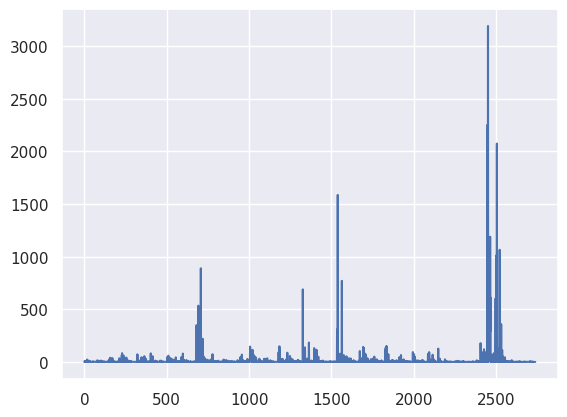

In [399]:
X_sample, _ = subsample(X, 40000, 42)
birch = train_BIRCH(X_sample, 100, 1.5)
# Get the cluster labels for each data point
labels = birch.labels_
X_subsample, labels_subsample = subsample(X_sample, 5000, 24, labels)
metrics = evaluate_model(X_subsample, labels_subsample)


# Print the scores
print("Silhouette Score: ", metrics[0])
print("Calinski-Harabasz Index: ", metrics[1])
print("Davies-Bouldin Index: ", metrics[2])

print(
    f"Num of clusters: {len([node for node in birch.subcluster_centers_])}"
)

plt.plot(np.bincount(labels))

## Hyperparameter optimisation

In [430]:
import time

def objective(trial):
    # BIRCH hyperparameters
    branching_factor = trial.suggest_int("branching_factor", 10, 200)
    threshold = trial.suggest_float("threshold", 0.1, 3)

    # Custom function parameters
    n_components_domain = trial.suggest_int("n_components_domain", 50, 350)
    n_components_subdomain = trial.suggest_int("n_components_subdomain", 50, 300)
    n_components_tld = trial.suggest_int("n_components_tld", 25, 100)
    n_high = trial.suggest_int("n_high", 2, 8)

    columns = trial.suggest_categorical(
        "columns", [["domain", "subdomain"], ["domain", "subdomain", "TLD"]]
    )

    n_components = [n_components_domain, n_components_subdomain]

    if len(columns) == 3:
        n_components.append(n_components_tld)

    start_tfidf = time.time()

    # Apply the custom function
    tfidf_lsas = preprocess_tfidf(
        columns=columns,
        ngram_range=(1, n_high),
        n_components=n_components,
        df=urls_extracted_df,
    )    

    X = sp.hstack((urls_sparse, tfidf_lsas[0], tfidf_lsas[1]), format="csr")

    end_tfidf = time.time()

    X_sample, _ = subsample(X, 40000, 42)

    start_birch = time.time()

    birch = train_BIRCH(
        X_sample, branching_factor=branching_factor, threshold=threshold
    )

    end_birch = time.time()

    labels = birch.labels_
    X_subsample, labels_subsample = subsample(X_sample, 5000, 24, labels)
    metrics = evaluate_model(X_subsample, labels_subsample)

    trial.set_user_attr("silhouette", metrics[0])
    trial.set_user_attr("calinski_harabasz", metrics[1])
    trial.set_user_attr("davies_bouldin", metrics[2])

    # Calculate time
    birch_time = end_birch - start_birch
    tfidf_time = end_tfidf - start_tfidf
    all_time = birch_time + tfidf_time

    trial.set_user_attr("tfidf_time", tfidf_time)
    trial.set_user_attr("birch_time", birch_time)
    trial.set_user_attr("all_time", all_time)

    num_of_clusters = len(np.bincount(labels))

    trial.set_user_attr("num_of_clusters", num_of_clusters)

    # Combine silhouette with time penalty as score
    score = metrics[0] + log(-0.2 * all_time + 1799) - 7.51

    return score

In [407]:
len(np.bincount(labels))

2738

In [ ]:
study = optuna.create_study(storage="sqlite:///optimalisation.db", study_name="birch_study")
study.optimize(objective, n_trials=700, n_jobs=-1)


[I 2023-04-30 23:23:59,980] A new study created in RDB with name: birch_study


In [433]:
for trial in test_study.trials:
    print(trial.user_attrs)

{'all_time': 494.2459719181061, 'birch_time': 14.284606218338013, 'calinski_harabasz': 72.94704889728222, 'davies_bouldin': 0.9999455009302008, 'num_of_clusters': 2193, 'silhouette': 0.05860840081118897, 'tfidf_time': 479.96136569976807}


In [429]:
# load the test_study from the database
test_study = optuna.load_study(study_name="birch_study", storage="sqlite:///optimalisation.db")

# print the trial results
for trial in test_study.trials:
    print(f'Trial {trial.number}: score={trial.value}, params={trial.params}')
    
    

Trial 0: score=-0.01291936389282533, params={'branching_factor': 32, 'columns': ['domain', 'subdomain', 'TLD'], 'n_components_domain': 71, 'n_components_subdomain': 241, 'n_components_tld': 98, 'n_high': 6, 'threshold': 1.6103023839418036}


## Data exploration

### Levenshtein distances

#### Domain unchanged

In [ ]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 50000

urls_tsdf = pd.DataFrame()

urls_tsdf["sample1"] = urls_tdf.sample(n=N_SAMPLES, random_state=123).reset_index(
    drop=True
)["domain"]
urls_tsdf["sample2"] = urls_tdf.sample(n=N_SAMPLES, random_state=545).reset_index(
    drop=True
)["domain"]

In [ ]:
# Calculate Levenshtein distance on each pair (N_SAMPLES distances)
urls_tsdf["levenshtein_distance_domain"] = urls_tsdf.apply(
    lambda row: levenshtein(row.sample1, row.sample2), axis=1
)

In [ ]:
urls_tsdf.describe()

In [ ]:
urls_tsdf

In [ ]:
sns.displot(
    urls_tsdf,
    x="levenshtein_distance_domain",
    binwidth=3,
    height=10,
)
plt.title(
    f"Distribution of levenshtein's distances among domains over {N_SAMPLES} random samples"
)

In [ ]:
sns.displot(
    urls_tsdf[urls_tsdf["levenshtein_distance_domain"] < 40],
    x="levenshtein_distance_domain",
    binwidth=1,
    height=8,
)
plt.title(
    f"Distribution of levenshtein's distances among domains over {N_SAMPLES} random samples"
)

## Experiments

### Unchanged URLs

Keep `urls_tdf` intact for this section to show what it should

#### DBSCAN

DBSCAN will not work. It needs $\mathcal{O}(n^2)$

#### Hierarchical clustering

In [ ]:
# Create two sets of N_SAMPLES random samples
N_SAMPLES = 1000

urls_tsdf = urls_tdf.sample(n=N_SAMPLES, random_state=111).reset_index(drop=True)

In [ ]:
# Calculate pairwise distances between domains using levenshtein distance function
X = urls_tsdf["domain"].values.reshape(-1, 1)
distances = pdist(X, metric=levenshtein_pdist)
distances_squareform = squareform(distances)

In [ ]:
# Perform hierarchical clustering
Z = linkage(distances, "complete")

# Draw dendrogram for visual cutoff selection
fig, ax = plt.subplots(figsize=(40, 20))
dendrogram(Z, ax=ax)


fig1 = fig
plt.show()

In [ ]:
CUTOFF = [42, 23, 19, 31]

# Load the figure object from the previous cell
fig = fig1

# Get the axes object from the figure
ax = fig.axes[0]

# Add the cutoff horizontal line
for cutoff in CUTOFF:
    ax.axhline(y=cutoff, color="r", linestyle="--")
    ax.text(x=ax.get_xlim()[0], y=cutoff, s=f"Cutoff: {cutoff}", va="center")


# Show the plot
fig

In [ ]:
# Determine the optimal number of clusters
max_d = 15  # set the threshold distance
clusters = fcluster(Z, max_d, criterion="distance")

In [ ]:
# Add cluster labels to the original dataset
urls_tsdf["cluster"] = clusters

#### Evaluation of cluster quality based on cutoff

In [ ]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
silhouette_avg = silhouette_score(
    distances_squareform, urls_tsdf["cluster"], metric="precomputed"
)
print(f"Silhouette score: {silhouette_avg}")

# calculate prevalence of malicious domains in each cluster
cluster_prevalence = urls_tsdf.groupby("cluster")["malicious"].mean()

# group by cluster id and count the number of items in each cluster
cluster_counts = urls_tsdf.groupby("cluster").count()["url"]

# create a dataframe combining the cluster counts and cluster prevalence
cluster_data = pd.DataFrame({"count": cluster_counts, "prevalence": cluster_prevalence})

# filter perfect clusters
non_trivial_clusters = cluster_data.loc[
    (cluster_data["prevalence"] != 0) & (cluster_data["prevalence"] != 1)
]

print(f"Total count of samples {len(urls_tsdf)}")
print(f"Total count of clusters {len(cluster_data)}")
print(
    f"Count of samples in perfect clusters {len(urls_tsdf) - non_trivial_clusters['count'].sum()}"
)

print(
    f"Prevalence of non-perfect malicious domains within clusters:\n{non_trivial_clusters}"
)

In [ ]:
# reset the index to get the cluster id as a column
cluster_data = cluster_data.reset_index()

# Create color palette
colors = sns.color_palette("viridis", as_cmap=True)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    x="cluster",
    y="prevalence",
    data=cluster_data,
    palette=colors(cluster_data["count"] / cluster_data["count"].max()),
    ax=ax,
    dodge=False,
)

# Set labels and title
ax.set_title("Prevalence of Malicious Domains by Cluster")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Prevalence")

# Move the legend outside the plot and make it a gradient line
sm = plt.cm.ScalarMappable(
    cmap=colors, norm=plt.Normalize(vmin=0, vmax=cluster_data["count"].max())
)
sm.set_array([])
cbar = plt.colorbar(
    sm,
    orientation="horizontal",
    pad=0.1,
    shrink=0.5,
    aspect=15,
)
cbar.ax.set_xlabel("Cluster Size")

plt.subplots_adjust(right=0.8)

plt.tight_layout()

plt.show()

In [ ]:
urls_tsdf.info()

In [ ]:
urls_tsdf.groupby("cluster").count()